# SberMarket Hackathon EDA

In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
from tqdm import tqdm

In [2]:
sub = pd.read_csv('sample_submission.csv')

In [3]:
tab1 = pd.read_csv('kaggle_tab_1345/tab_1_orders.csv')
tab3 = pd.read_csv('kaggle_tab_1345/tab_3_categories.csv')
tab4 = pd.read_csv('kaggle_tab_1345/tab_4_user_profiles.csv')
tab5 = pd.read_csv('kaggle_tab_1345/tab_5_product_properties.csv')

### Table 1 (orders):

```order_id | user_id | order_completed_date | store_id | retailer | platform```

In [4]:
tab1.head()

,user_id,order_id,order_created_time,retailer,store_id,platform
0,72,17431000,2020-09-26 10:48:57,METRO,21,app
1,83,9718154,2020-05-08 09:46:18,METRO,87,web
2,142,10056850,2020-05-14 15:06:03,METRO,320,app
3,187,15952443,2020-09-01 17:34:00,ВкусВилл,533,app
4,224,10409918,2020-05-20 06:32:50,Ашан,183,web


In [5]:
tab1.user_id.nunique(), tab1.order_id.nunique(), tab1.retailer.nunique(), tab1.store_id.nunique()

(753572, 2426955, 61, 738)

In [6]:
user_to_orders = tab1.groupby('user_id').order_id.apply(set)
order_to_user = dict(zip(tab1.order_id, tab1.user_id))

### Timestamps

In [7]:
order_to_dt = pd.DataFrame(tab1.iloc[:, 1])
timestamps = pd.to_datetime(tab1.order_created_time)

In [8]:
order_to_dt['month'] = timestamps.dt.month
order_to_dt['weekday'] = timestamps.dt.weekday
order_to_dt['day'] = timestamps.dt.day

In [9]:
order_to_dt.head()

,order_id,month,weekday,day
0,17431000,9,5,26
1,9718154,5,4,8
2,10056850,5,3,14
3,15952443,9,1,1
4,10409918,5,2,20


In [10]:
order_to_dt_ = order_to_dt.set_index('order_id')

In [11]:
order_to_period = {'month':dict(zip(order_to_dt.order_id.values, order_to_dt.loc[:,'month'].values)),
                   'weekday':dict(zip(order_to_dt.order_id.values, order_to_dt.loc[:,'weekday'].values)),
                   'day':dict(zip(order_to_dt.order_id.values, order_to_dt.loc[:,'day'].values))}

### Retailers and stores

In [12]:
order_to_retailer = dict(zip(tab1.order_id.values, tab1.retailer.values))

In [13]:
tab1.retailer.value_counts()

METRO                   1369726
Лента                    653387
Ашан                     401004
МЕГАМАРТ                  11006
ВкусВилл                   8821
                         ...   
АГРОКОМПЛЕКС                  4
Сыроварня DolceLatte          3
ТД "Закарпатье"               2
МЯСНИЦКИЙ РЯД                 1
Империал                      1
Name: retailer, Length: 61, dtype: int64

### Platform

In [14]:
order_to_platform = dict(zip(tab1.order_id.values, tab1.platform.values))

In [15]:
tab1.platform.value_counts()

app          1872404
web           513018
undefined      76536
Name: platform, dtype: int64

### Table 3 (categories):

```category_id | category_name | parent_category_id```

category is a higher category level over master_category.

In [16]:
tab3.head()

,id,name,parent_id
0,1,Продукты питания,0
1,2,Замороженные продукты,1
2,3,Замороженные овощи и фрукты,2
3,4,Замороженные полуфабрикаты,2
4,5,Рыба замороженная,2


In [17]:
tab3.id.nunique(), tab3.name.nunique(), tab3.parent_id.nunique()

(1016, 947, 140)

I rewrite all parents categories with one name, hence created parent-parent category due to similar names. I created separate file and read it.

In [18]:
cat_to_names = pd.read_csv('parent_category_names.csv', index_col=0)
cat_to_names 

,name,one_name,one_name_eng
parent_id,,,
0,Продукты питания -- Детские товары -- Косметик...,Для дома,For the house
1,"Замороженные продукты -- Бакалея -- Чипсы, сух...",Бакалея,Grocery
2,Замороженные овощи и фрукты -- Замороженные по...,Замороженные,Frozen
9,"Хлопья, мюсли, сухие завтраки -- Макароны -- К...",Бакалея,Grocery
19,"Чипсы -- Сухарики и гренки -- Попкорн, кукуруз...",Снеки,Sneeks
...,...,...,...
569,Антибактериальные и противомикробные средства ...,Здоровье,Health
570,Витамины -- БАДы и пищевые добавки,Здоровье,Health
571,Перевязочные материалы -- Расходные материалы ...,Здоровье,Health


In [19]:
parent_id_to_name = dict(zip(cat_to_names.index.values, cat_to_names.one_name_eng))

In [459]:
# cat_to_names.to_csv('parent_category_names.csv' )

### Table 4 (user_profiles):

```user_id | gender | bdate```

In [20]:
tab4.head()

,user_id,gender,bdate
0,2224890,NaN,NaN
1,1683001,male,1987-10-11
2,2102480,NaN,NaN
3,2224895,NaN,NaN
4,930197,NaN,NaN


In [21]:
tab4.shape[0], tab4.isna().sum(0) / tab4.shape[0]

(438867,
 user_id    0.000000
 gender     0.528035
 bdate      0.528361
 dtype: float64)

In [22]:
user_to_dem = tab4.dropna().copy()

In [23]:
user_to_dem.user_id.nunique(), user_to_dem.gender.value_counts() / user_to_dem.shape[0]

(206730,
 female    0.631833
 male      0.368167
 Name: gender, dtype: float64)

In [24]:
user_to_dem.loc[:, 'bdate'] = pd.to_datetime(user_to_dem.bdate, errors='coerce', format="%Y-%m-%d")
user_to_dem.dropna(inplace=True)

In [25]:
user_to_dem.loc[:, 'year'] = user_to_dem.bdate.dt.year

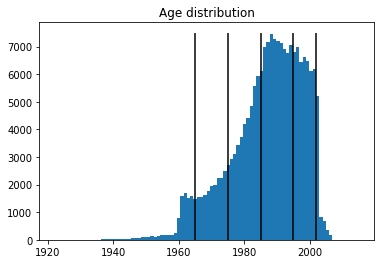

In [26]:
plt.title('Age distribution')
plt.hist(user_to_dem.year, bins=92)
plt.vlines([2002, 1995, 1985, 1975, 1965], 0, 7500)
plt.show()

In [27]:
# our hypothesis agegroups
agegroup_b = [1955, 1965, 1975, 1985, 1995, 2002]
agegroup = pd.cut(user_to_dem.year.values, agegroup_b, labels=False)

In [28]:
# quantilled agegroups
agegroup_q, agegroup_qb = pd.qcut(user_to_dem.year.values, [0, .01, .25, .5, .75, 0.99, 1.], labels=False, retbins=True)

In [29]:
# yeah, we don't use small groups - <1955 and >2002
agegroup_b, agegroup_qb

([1955, 1965, 1975, 1985, 1995, 2002],
 array([1922., 1959., 1980., 1988., 1995., 2003., 2015.]))

In [30]:
agebins = [f'{agegroup_b[i]}-{agegroup_b[i+1]}' for i in range(len(agegroup_b)-1)]
agebins

['1955-1965', '1965-1975', '1975-1985', '1985-1995', '1995-2002']

In [31]:
user_to_dem.loc[:, 'agegroup'] = agegroup
user_to_dem = user_to_dem.dropna()
user_to_dem.loc[:, 'agegroup'] = user_to_dem.agegroup.astype(int)

In [32]:
youngold  = pd.cut(user_to_dem.year.values, [1955, 1985, 2002], labels=False)
user_to_dem.loc[:, 'youngold'] = youngold

In [33]:
# user_to_dem = user_to_dem.set_index('user_id')
user_to_dem.head()

,user_id,gender,bdate,year,agegroup,youngold
1,1683001,male,1987-10-11,1987,3,1
10,1288925,male,1982-09-24,1982,2,0
22,631583,male,1989-03-16,1989,3,1
41,2106256,male,1978-12-04,1978,2,0
48,534410,female,1990-10-31,1990,3,1


In [34]:
user_to_agegroup = dict(zip(user_to_dem.user_id.values, user_to_dem.agegroup.values))
user_to_gender = dict(zip(user_to_dem.user_id.values, user_to_dem.gender.values))
user_to_yo = dict(zip(user_to_dem.user_id.values, user_to_dem.youngold.values))

### Table 2 (products):

```user_id | order_id | line_item_id | price | quantity | discount | product_name | product_id | brand_name | master_category```

master_category is the lowest level category. Each product belongs to one master_category.

line_item_id is the product's position in the order.

price is the actual amount of money the user paid for the product. The discount is calculated as difference between the price which the user payed and the regular price of this product.

In [35]:
# cols = 'user_id order_id price quantity discount parent_category_id'.split()
cols = 'user_id order_id price quantity discount brand_name parent_category_id'.split()
dtypes = dict(zip(cols, [np.uint32, np.uint32, np.float32, np.uint16, np.float32, np.object, np.uint32]))

In [36]:
# ALL : 60 mil rows
tables = []
for folder in filter(lambda x: x.startswith('sber'), os.listdir()):
    for table in os.listdir(folder):
        tables.append(pd.read_csv(folder+ '/' + table, 
                                 dtype=dtypes, usecols=cols))

In [ ]:
# # BEFORE quarantine - january february march : 9 million rows
# tables = []
# for table in os.listdir('sbermarket_tab_2_1'):
#     tables.append(pd.read_csv('sbermarket_tab_2_1/' + table))

In [ ]:
# # JANUARY : 1.8 mil
# tables = []
# for table in filter(lambda x: x.startswith('tab_2_products_2020-01'), os.listdir('sbermarket_tab_2_1')):
#     tables.append(pd.read_csv('sbermarket_tab_2_1/' + table))

In [ ]:
# # FEBRUARY : 2.2 mil
# tables = []
# for table in filter(lambda x: x.startswith('tab_2_products_2020-02'), os.listdir('sbermarket_tab_2_1')):
#     tables.append(pd.read_csv('sbermarket_tab_2_1/' + table))

In [ ]:
# # MARCH : 5 mil
# tables = []
# for table in filter(lambda x: x.startswith('tab_2_products_2020-03'), os.listdir('sbermarket_tab_2_1')):
#     tables.append(pd.read_csv('sbermarket_tab_2_1/' + table))

In [ ]:
# # AFTER quarantine : 50 million rows
# tables = []
# for folder in filter(lambda x: x.startswith('sbermarket_tab_2') and not x.endswith('_1'), os.listdir()):
#     for table in os.listdir(folder):
#         tables.append(pd.read_csv(folder + '/'+ table))

In [ ]:
# # AFTER quarantine 1/3 of data : ~16 million
# tables = []
# for folder in filter(lambda x: x.startswith('sbermarket_tab_2') and not x.endswith('_1'), os.listdir()):
#     tables.append(pd.read_csv(folder + '/'+ random.choice(os.listdir(folder))))

In [ ]:
# # APRIL - JUST after quarantine : 9 million
# tables = []
# for table in os.listdir('sbermarket_tab_2_2'):
#     tables.append(pd.read_csv('sbermarket_tab_2_2/'+ table))

In [ ]:
# # MAY
# tables = []
# for table in os.listdir('sbermarket_tab_2_3'):
#     tables.append(pd.read_csv('sbermarket_tab_2_3/'+ table))

In [ ]:
# # JUNE: 9mil
# tables = []
# for table in os.listdir('sbermarket_tab_2_4'):
#     tables.append(pd.read_csv('sbermarket_tab_2_4/'+ table))

In [ ]:
# # AUGUST - September : 12 million rows
# tables = []
# for table in os.listdir('sbermarket_tab_2_6'):
#     tables.append(pd.read_csv('sbermarket_tab_2_6/'+ table))

In [37]:
tab2 = pd.concat(tables)

In [38]:
print(f'{tab2.shape[0]} mln rows total!')

59596980 mln rows total!


In [39]:
tab2.head()

,user_id,order_id,price,quantity,discount,brand_name,parent_category_id
0,525,5354800,116.000000,4,0.00,Золотой Петушок,99
1,525,5354800,56.990002,2,13.08,Хлебный Дом,51
2,525,5354800,64.989998,2,40.02,Delicados,51
3,525,5354800,44.990002,6,0.00,BonAqua,74
4,525,5354800,65.900002,6,30.99,Mirinda,74


In [40]:
tab2.loc[:, 'price_total'] = (tab2.price) * tab2.quantity #(tab2.price + discount) * tab2.quantity

In [44]:
tab2.loc[:, 'category'] = tab2.parent_category_id.map(parent_id_to_name)

In [45]:
tab2.loc[:, 'is_discount'] = tab2.discount.astype(bool)

### Brands

In [46]:
brand_income = tab2.groupby('brand_name').price_total.sum().sort_values()[::-1]

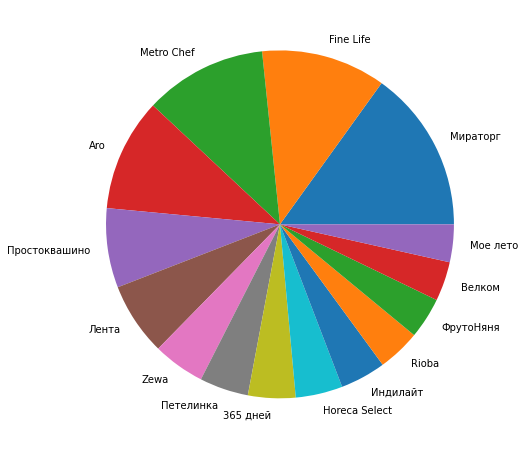

In [47]:
plt.figure(figsize=(8,8))
plt.pie(brand_income[1:16], labels=brand_income[1:16].index)
plt.savefig('brands.pdf')
plt.show()

## category quantity vs timestamp (weekday)

In [48]:
small_tab2_cat = tab2.loc[:, ['order_id', 'quantity', 'category']]
small_tab2_cat_period = small_tab2_cat[small_tab2_cat.order_id.isin(order_to_dt.order_id.values)].copy()

In [227]:
def changing_cats(per, N, mi, top, save=None):   
    ssmall_tab2_cat_period = small_tab2_cat_period.copy() # not a bug, feature... it starts in ~july
    
    ssmall_tab2_cat_period.loc[:, per] = small_tab2_cat_period.order_id.map(order_to_period[per])
    category_by_period = ssmall_tab2_cat_period.iloc[:, 1:].groupby(['category', per]).quantity.sum()
    category_by_period = category_by_period[category_by_period > mi].copy()
    catbyw_index = list(category_by_period.index.values) #names
    allcats = sorted(set([c for c, w in catbyw_index])) # all names

    bad_cat = [] # not full period
    for c in allcats:
        for w in range(*N):
            if (c, w) not in catbyw_index:
                bad_cat.append(c)
                break
    

    category_by_period = category_by_period.drop(bad_cat).copy()
    cat_by_period = category_by_period.values.reshape(-1, N[1]-N[0])
    allcats = sorted(set([c for c, w in category_by_period.index.values]))
    # detrend ?

    # by absolute difference
    maxabs_through_period = np.argsort((abs(cat_by_period.max(1) - cat_by_period.min(1)) / cat_by_period.max(1)))[-top:]
    maxabs_through_period = [allcats[i] for i in maxabs_through_period]
    # we can try another function or try exact period's elements (e.g. friday vs tuesday, jan vs aug)
    
    a = 1
    plt.figure(figsize=(15, 20))
    plt.suptitle(f"Top-{top} categories with trends through {per}s (min quantity = {mi})")
    for i in maxabs_through_period:
        plt.subplot(top // 3 + 1, 3, a)
        plt.title(i)
        plt.plot(category_by_period[i].values)
#         plt.xticks(range(7), 'Mon Tue Wed Thu Fri Sat Sun'.split())
        plt.xticks(range(9), 'Jan Feb Mar Apr May Jun Jul Aug Sep'.split())
        if (a % 3 == 1):
            plt.ylabel('quantity sold')
        a += 1
    if save is not None:
        plt.savefig(save)

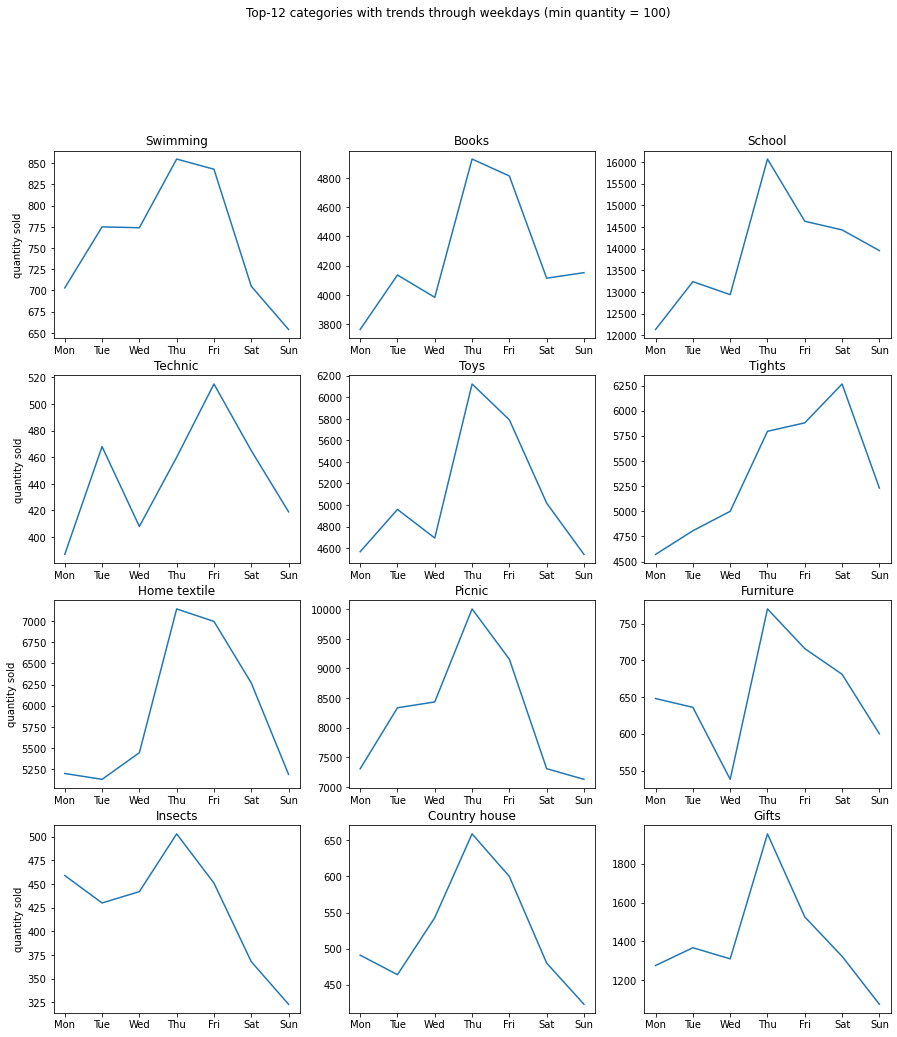

In [50]:
changing_cats('weekday', (0, 7), 100, 12, save='cat_by_WEEK_top9_all.png')

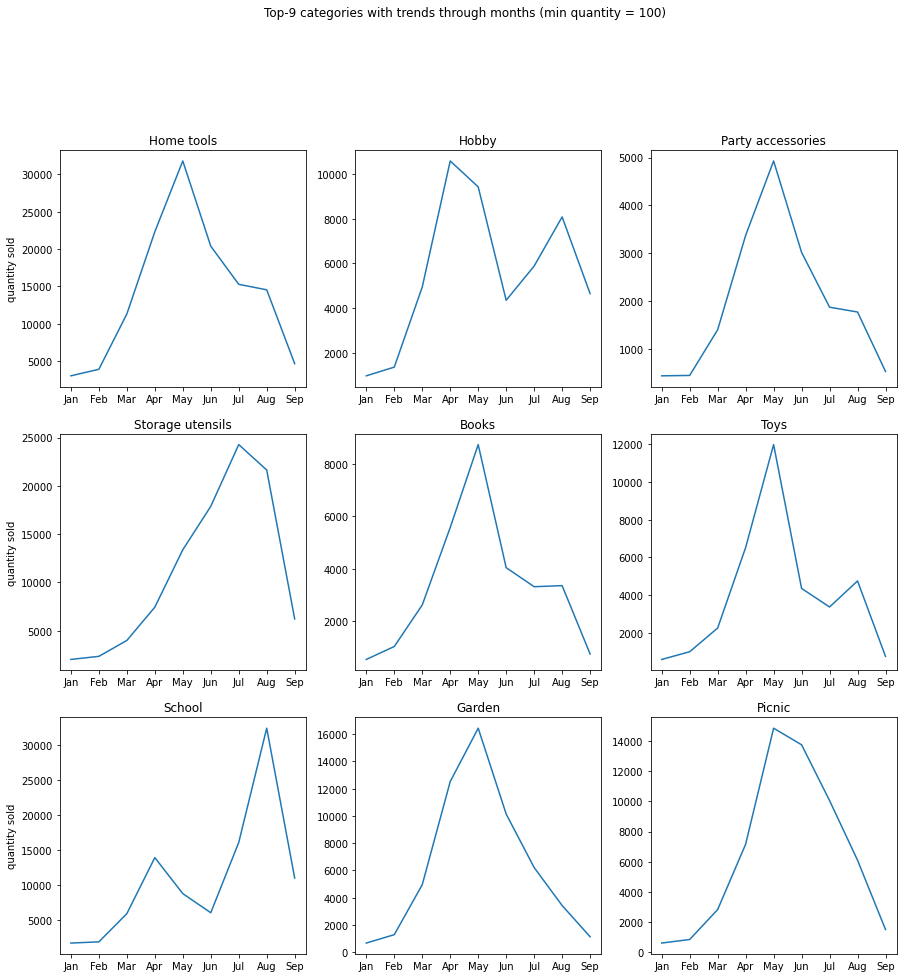

In [228]:
changing_cats('month', (1,10), 100, 9, save='cat_by_MONTH_top9_all.png')

## Changes through months by age groups

In [52]:
small_tab2_price = tab2.loc[:, ['user_id', 'order_id', 'price_total']].copy()
small_tab2_price = small_tab2_price[small_tab2_price.order_id.isin(order_to_dt_.index)].copy()

In [53]:
small_tab2_price.loc[:, 'month'] =  small_tab2_price.order_id.map(order_to_period['month'])
small_tab2_price.loc[:, 'age'] =  small_tab2_price.user_id.map(user_to_agegroup)

In [54]:
price_going_by_age = small_tab2_price.groupby(['age','month']).price_total.sum().values.reshape(-1, 9)

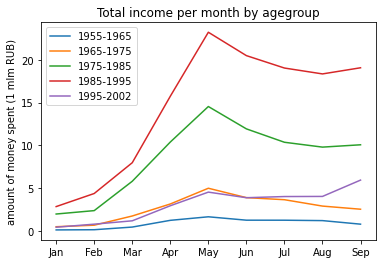

In [55]:
plt.plot(price_going_by_age.T)
plt.legend(agebins)
plt.title('Total income per month by agegroup')
plt.xticks(range(9), 'Jan Feb Mar Apr May Jun Jul Aug Sep'.split())
plt.ylabel('amount of money spent (1 mlm RUB)')
plt.yticks(np.arange(0, 2.1, 0.5)*1e7, np.arange(0, 21, 5))
plt.savefig('price_change.png')
plt.show()

## Gender dependant categories

In [56]:
small_tab2_user = tab2[tab2.user_id.isin(user_to_dem.user_id)].copy()
small_tab2_user = small_tab2_user.drop(labels=['order_id'], axis=1)

In [57]:
small_tab2_user.loc[:, 'gender'] = small_tab2_user.user_id.map(user_to_gender)

In [58]:
pricecat_gender = pd.DataFrame(small_tab2_user.groupby(['gender', 'category']).quantity.sum())

In [59]:
pricecat_gender.loc['female'].loc[:, 'quantity'] = \
pricecat_gender.loc['female'].loc[:, 'quantity'] / user_to_dem.gender.value_counts()['female']

In [60]:
pricecat_gender.loc['male'].loc[:, 'quantity'] = \
pricecat_gender.loc['male'].loc[:, 'quantity'] / user_to_dem.gender.value_counts()['male']

In [61]:
pricecat_gender

quantity
gender category                  
female Air freshener     0.020642
       Alcohol           0.000008
       Animals           0.004499
       Appliances        0.000332
       Auto              0.002415
...                           ...
male   Tools             0.083332
       Tourism           0.000073
       Toys              0.003468
       Vegetables        0.995121
       intimate hygiene  0.037727

[155 rows x 1 columns]

In [62]:
common_cats = pricecat_gender.loc['male'].index & pricecat_gender.loc['female'].index
cats_female = pricecat_gender.loc['female'].loc[common_cats]
cats_male = pricecat_gender.loc['male'].loc[common_cats]

In [63]:
percentage_diff = (cats_female / cats_male).sort_values('quantity') 
maxdiff_female = (percentage_diff > 2) 
maxdiff_male = (percentage_diff < 0.5)
maxdiff_index_f = maxdiff_female.loc[maxdiff_female.values.ravel()].index
maxdiff_index_m = maxdiff_male.loc[maxdiff_male.values.ravel()].index

In [64]:
maxdiff_index_sorted_f = cats_female.loc[maxdiff_index_f].sort_values('quantity').index
maxdiff_index_sorted_m = cats_male.loc[maxdiff_index_m].sort_values('quantity').index

In [65]:
cats_female_f = cats_female.loc[maxdiff_index_sorted_f]
cats_male_f = cats_male.loc[maxdiff_index_sorted_f]

cats_female_m = cats_female.loc[maxdiff_index_sorted_m]
cats_male_m = cats_male.loc[maxdiff_index_sorted_m]

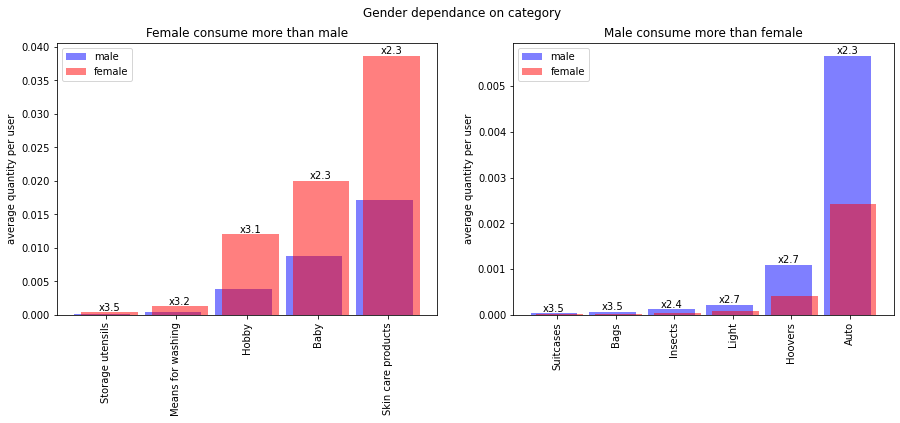

In [66]:
plt.figure(figsize=(15, 5))
plt.suptitle('Gender dependance on category')
plt.subplot(1,2,1)
plt.bar(np.array(range(len(cats_male_f)))-0.05, 
        cats_male_f.values.ravel(), alpha=0.5, color='b', label='male')
barsf=plt.bar(np.array(range(len(cats_female_f)))+0.05, 
        cats_female_f.values.ravel(), alpha=0.5, color='r', label='female')
for rect, t in zip(barsf, percentage_diff.loc[maxdiff_index_sorted_f].values.ravel()):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, 
             height, 'x'+str(t.round(1)), ha='center', va='bottom')
plt.xticks(range(len(maxdiff_index_f)), maxdiff_index_f.values, rotation=90)
plt.legend()
plt.title('Female consume more than male')
plt.ylabel('average quantity per user')

plt.subplot(1,2,2)
barsm = plt.bar(np.array(range(len(cats_male_m)))-0.05, 
        cats_male_m.values.ravel(), alpha=0.5, color='b', label='male')
plt.bar(np.array(range(len(cats_female_m)))+0.05, 
        cats_female_m.values.ravel(), alpha=0.5, color='r', label='female')
plt.xticks(range(len(maxdiff_index_m)), maxdiff_index_m.values, rotation=90)
for rect, t in zip(barsm, 1/percentage_diff.loc[maxdiff_index_sorted_m].values.ravel()):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, 
             height, 'x'+str(t.round(1)), ha='center', va='bottom')

    
plt.legend()
plt.title('Male consume more than female')
plt.ylabel('average quantity per user')

plt.savefig('gender_dif.png')
plt.show()

## Age dependant categories

In [67]:
small_tab2_user.loc[:, 'youngold'] = small_tab2_user.user_id.map(user_to_yo)

pricecat_youngold = pd.DataFrame(small_tab2_user.groupby(['youngold', 'category']).quantity.sum())
pricecat_youngold.loc[0].loc[:, 'quantity'] = \
pricecat_youngold.loc[0].loc[:, 'quantity'] / user_to_dem.youngold.value_counts()[0]
pricecat_youngold.loc[1].loc[:, 'quantity'] = \
pricecat_youngold.loc[1].loc[:, 'quantity'] / user_to_dem.youngold.value_counts()[1]
pricecat_youngold

quantity
youngold category                  
0        Air freshener     0.017521
         Alcohol           0.000014
         Animals           0.003702
         Appliances        0.000244
         Auto              0.003228
...                             ...
1        Tourism           0.000061
         Toys              0.004678
         Vegetables        1.050573
         Winterization     0.000009
         intimate hygiene  0.050626

[155 rows x 1 columns]

In [68]:
common_cats = pricecat_youngold.loc[1].index & pricecat_youngold.loc[0].index
cats_old = pricecat_youngold.loc[0].loc[common_cats]
cats_young = pricecat_youngold.loc[1].loc[common_cats]
percentage_diff = (cats_old / cats_young).sort_values('quantity') 

In [69]:
maxdiff_old = (percentage_diff > 1.8) 
maxdiff_young = (percentage_diff < 0.6)
maxdiff_index_0 = maxdiff_old.loc[maxdiff_old.values.ravel()].index
maxdiff_index_1 = maxdiff_young.loc[maxdiff_young.values.ravel()].index
maxdiff_index_sorted_0 = cats_old.loc[maxdiff_index_0].sort_values('quantity').index
maxdiff_index_sorted_1 = cats_young.loc[maxdiff_index_1].sort_values('quantity').index

In [70]:
cats_old_0 = cats_old.loc[maxdiff_index_sorted_0]
cats_young_0 = cats_young.loc[maxdiff_index_sorted_0]

cats_old_1 = cats_old.loc[maxdiff_index_sorted_1]
cats_young_1 = cats_young.loc[maxdiff_index_sorted_1]

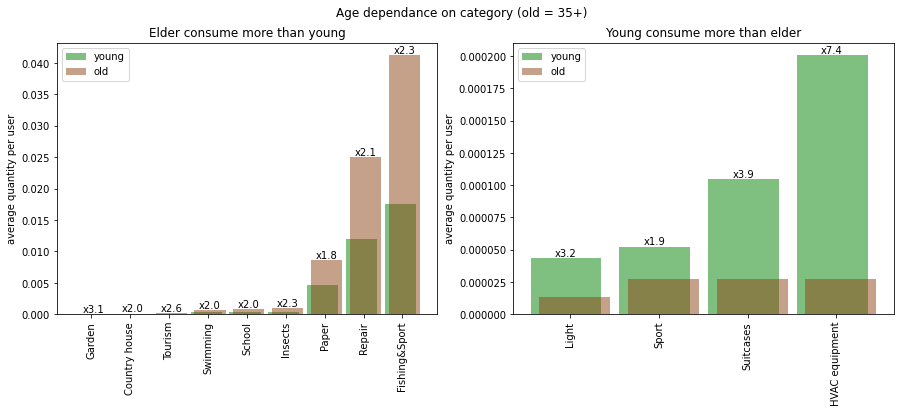

In [71]:
plt.figure(figsize=(15, 5))
plt.suptitle('Age dependance on category (old = 35+)')
plt.subplot(1,2,1)
plt.bar(np.array(range(len(cats_young_0)))-0.05, 
        cats_young_0.values.ravel(), alpha=0.5, color='g', label='young')
barsf=plt.bar(np.array(range(len(cats_old_0)))+0.05, 
        cats_old_0.values.ravel(), alpha=0.5, color='saddlebrown', label='old')
for rect, t in zip(barsf, percentage_diff.loc[maxdiff_index_sorted_0].values.ravel()):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, 
             height, 'x'+str(t.round(1)), ha='center', va='bottom')
plt.xticks(range(len(maxdiff_index_0)), maxdiff_index_0.values, rotation=90)
plt.legend()
plt.title('Elder consume more than young')
plt.ylabel('average quantity per user')

plt.subplot(1,2,2)
barsm = plt.bar(np.array(range(len(cats_young_1)))-0.05, 
        cats_young_1.values.ravel(), alpha=0.5, color='g', label='young')
plt.bar(np.array(range(len(cats_old_1)))+0.05, 
        cats_old_1.values.ravel(), alpha=0.5, color='saddlebrown', label='old')
plt.xticks(range(len(maxdiff_index_1)), maxdiff_index_1.values, rotation=90)
for rect, t in zip(barsm, 1/percentage_diff.loc[maxdiff_index_sorted_1].values.ravel()):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, 
             height, 'x'+str(t.round(1)), ha='center', va='bottom')

    
plt.legend()
plt.title('Young consume more than elder')
plt.ylabel('average quantity per user')

plt.savefig('gender_dif.png')
plt.show()

## Platform and retailer by demographic group

In [72]:
small_tab2_ord = tab2.iloc[:, [0,1,7]]

In [73]:
small_tab2_ord = small_tab2_ord[small_tab2_ord.user_id.isin(user_to_dem.user_id)].copy()
small_tab2_ord = small_tab2_ord[small_tab2_ord.order_id.isin(tab1.order_id)].copy()

In [74]:
small_tab2_ord = small_tab2_ord.groupby(['user_id', 'order_id']).price_total.sum().reset_index()

In [75]:
small_tab2_ord.loc[:, 'agegroup'] = small_tab2_ord.user_id.map(user_to_agegroup)

In [76]:
small_tab2_ord.loc[:, 'retailer'] = small_tab2_ord.order_id.map(order_to_retailer)

In [77]:
retailer_dist = small_tab2_ord.groupby('agegroup').retailer.value_counts()
age_num = small_tab2_ord.agegroup.value_counts()

In [78]:
sorted_top3 = retailer_dist.loc[3].sort_values()[-3:]

In [79]:
plt.figure(figsize=(10,5))
for i, c in enumerate('lightcoral sandybrown skyblue plum pink'.split()):
    plt.bar(np.arange(len(sorted_top3))+(0.1)*i, 
            (retailer_dist.loc[i].loc[sorted_top3.index].values) / (age_num[i]), width=0.1, color=c)
plt.title('Retailer distribution by agegroup')
plt.legend(agebins)
plt.xticks(np.arange(len(sorted_top3))+0.2, sorted_top3.index)
plt.ylabel('orders quantity ratio (%)')
plt.show()

NameError: name 'yo_num' is not defined

<Figure size 720x360 with 0 Axes>

In [ ]:
# --------------------------------------------------------------------

In [ ]:
small_tab2_ord.loc[:, 'platform'] = small_tab2_ord.order_id.map(order_to_platform)

In [ ]:
small_tab2_ord_pl = small_tab2_ord.loc[small_tab2_ord.platform != 'undefined']

In [ ]:
pl_dist = small_tab2_ord_pl.groupby(['platform']).agegroup.value_counts()

In [ ]:
colors = 'lightcoral sandybrown skyblue plum pink'.split()
explode = (0.15, 0.15, 0, 0, 0.15)
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_title('App platform')
sizes = pl_dist['app'].sort_index().values
ax1.pie(sizes, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors)
ax1.axis('equal')
ax2.set_title('Web platform')
labels = pl_dist['web'].sort_index().index
sizes = pl_dist['web'].sort_index().values
ax2.pie(sizes, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors)
ax2.axis('equal')
ax2.legend([agebins[i] for i in pl_dist['web'].sort_index().index], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('platforms.png')
plt.show()

## Budget Range

In [81]:
tab2

,user_id,order_id,price,quantity,discount,brand_name,parent_category_id,price_total,category,is_discount
0,525,5354800,116.000000,4,0.000000,Золотой Петушок,99,464.000000,Semis,False
1,525,5354800,56.990002,2,13.080000,Хлебный Дом,51,113.980003,Bread products,True
2,525,5354800,64.989998,2,40.020000,Delicados,51,129.979996,Bread products,True
3,525,5354800,44.990002,6,0.000000,BonAqua,74,269.940002,Drinks,False
4,525,5354800,65.900002,6,30.990000,Mirinda,74,395.400024,Drinks,True
...,...,...,...,...,...,...,...,...,...,...
3167950,3142966,16654689,34.889999,1,17.700001,Epica,20,34.889999,Dairy,True
3167951,3142966,16654689,63.889999,1,73.000000,Ritter Sport,56,63.889999,Sweets,True
3167952,3142966,16654689,63.889999,1,82.500000,Ritter Sport,56,63.889999,Sweets,True
3167953,3142966,16654689,298.489990,1,0.000000,Троекурово,119,298.489990,Meat,False


In [83]:
expensive_products_user = tab2.groupby('user_id').price.max()

In [84]:
amount_money_spent_user = tab2.groupby('user_id').price_total.sum()

In [86]:
discount_likely_user = tab2.groupby('user_id').is_discount.mean()

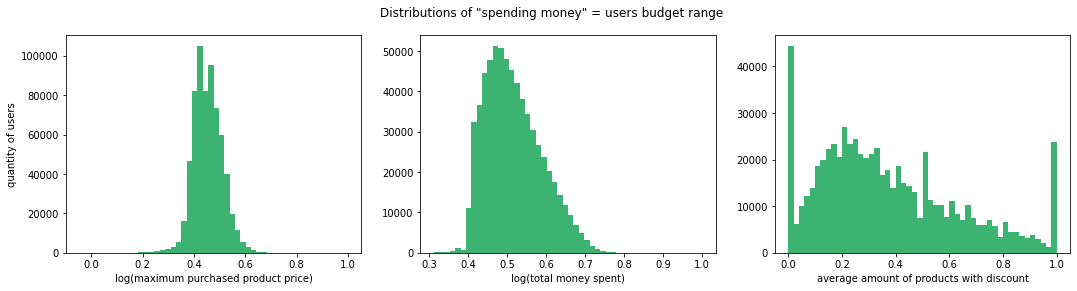

In [170]:
plt.figure(figsize=(18,4))
plt.suptitle('Distributions of "spending money" = users budget range')
plt.subplot(131)
plt.hist(np.log(expensive_products_user.values)/np.log(expensive_products_user.values.max()), 
         bins=50, color='mediumseagreen')
plt.ylabel('quantity of users')
plt.xlabel('log(maximum purchased product price)')
plt.subplot(132)
plt.hist(np.log(amount_money_spent_user.values)/np.log(amount_money_spent_user.values.max()), bins=50,  color='mediumseagreen')
# plt.ylabel('quantity of users')
plt.xlabel('log(total money spent)')
plt.subplot(133)
plt.hist((discount_likely_user.values), bins=50,  color='mediumseagreen')
# plt.ylabel('quantity of users')
plt.xlabel('average amount of products with discount')
plt.savefig()
plt.show()

$$\text{budget_metric}_{u} = \frac{\log(\text{max_price_product}_{u}) * \log(\text{total_money_spent}_{u}) }{\log(\text{max_price_product}_{\max_u}) * \log(\text{total_money_spent}_{\max_u})} \cdot \exp((\text{is_discount_avg}_{u} + \varepsilon)^{-1})$$

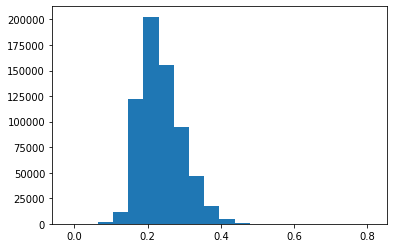

In [196]:
func_money = np.log(expensive_products_user.values) \
         * np.log(amount_money_spent_user.values)\
         * np.exp(1 / (discount_likely_user.values + 1e3)) \
         / (np.log(expensive_products_user.values.max()) \
            * np.log(amount_money_spent_user.values.max()))
        
plt.hist(func_money, bins=20)
plt.show()

In [202]:
np.quantile(func_money, [0.2, 0.5, 0.8])

array([0.18784799, 0.22815349, 0.28387664])

In [208]:
func_user = pd.DataFrame(expensive_products_user)
func_user.loc[:, 'func'] = func_money
func_user = func_user.drop('price', 1)

In [213]:
budget_range = pd.qcut(func_user.func, [0, 0.2, 0.5, 0.8, 1], labels=False)

In [214]:
func_user.loc[:, 'budget'] = budget_range

In [215]:
func_user

,func,budget
user_id,,
51,0.422846,3
65,0.387595,3
83,0.255181,2
142,0.185568,0
187,0.159613,0
...,...,...
3142901,0.145487,0
3142924,0.189606,1
3142936,0.154150,0


In [217]:
user_to_budget = dict(zip(func_user.index.values, func_user.budget.values))

In [218]:
tab2.loc[:, 'budget'] = tab2.user_id.map(user_to_budget)

In [222]:
budget_brand = tab2.groupby('budget').brand_name.value_counts()

In [226]:
for i in range(4):
    print(i)
    print(budget_brand.loc[i][1:10])
    print('----------')

0
brand_name
Лента            64255
365 дней         52203
Простоквашино    35331
ФрутоНяня        32831
Aro              32750
Fine Life        28968
Мое лето         20336
Lay's            19005
Heinz            18628
Name: brand_name, dtype: int64
----------
1
brand_name
Лента            149057
365 дней         119205
Aro              105347
Fine Life        104580
Простоквашино     98330
ФрутоНяня         71167
Мое лето          57024
Makfa             49064
Heinz             47618
Name: brand_name, dtype: int64
----------
2
brand_name
Fine Life        308554
Лента            295516
Aro              293123
Простоквашино    242625
365 дней         215627
ФрутоНяня        177143
Мое лето         126744
Мираторг         125075
Heinz            117084
Name: brand_name, dtype: int64
----------
3
brand_name
Fine Life        916876
Aro              792678
Простоквашино    610846
ФрутоНяня        461358
Лента            443713
Мираторг         388216
Metro Chef       370318
Агуша          

## Categories vs categories dependance (milk + oats)

In [231]:
small_tab2_prod = tab2.drop(['user_id', 'price', 'quantity', 'discount', 'price_total', 'is_discount', 'budget'], axis=1)

In [242]:
tmp = pd.DataFrame(small_tab2_prod[-1000000:].groupby('order_id').category.value_counts())
tmp

category
order_id category             
2749435  Dairy               5
         Vegetables          3
         Grocery             1
         Paper funds         1
         Sauces              1
...                        ...
16831182 Dairy               3
         Semis               3
         Cheese              1
         Sauces              1
         Sneeks              1

[392581 rows x 1 columns]

array([15948638, 16494232, 14975273, ..., 16831182, 15623327, 16654689],
      dtype=uint32)

In [249]:
import itertools

In [244]:
pairs_cat = dict()
for i in (small_tab2_prod[-1000000:].order_id.unique()):
    cats = tmp.loc[i].index.values
    for pair in itertools.permutations(cats, repeat=2):

ValueError: cannot insert category, already exists